# Google Analytics Customer Revenue Prediction

### Group Members
* Zili Bu
* Hsin-Yu Chen
* Kexin Zhang
* Huang-Chin Yen

### Executive Summary

### Introduction
* What dataset you used and your initial plan

We found Google Analytics Customer Revenue Prediction dataset from Kaggle. Our initial plan is to clean the dataset, explore the dataset by plots, use spark sql to do further analysis to get an insight about user behaviors. 

### Exploratory analysis section
* Any insights you've learned from the data (with charts to illustrate)

In [1]:
# import needed libraries
import pandas as pd
import numpy as np

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkContext
sc = SparkContext()

In [4]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
spark = SparkSession.builder.appName("Project-DNSC6290").getOrCreate()

In [6]:
from time import time

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json file
import os # it's a operational system library, to set some informations

In [9]:
data = pd.read_csv("train.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
data.head(1)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385


In [11]:
pwd

'/Users/hyen86/BigData/Project'

## Convert Json Columns

In [12]:
#dir_path = "/Users/hyen86/BigData/Project/"
def load_df(df, nrows = None):
    # Columns that have json format
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    #nrows = None
    
    df = pd.read_csv("train.csv", 
                converters={column: json.loads for column in json_columns}, 
                dtype={'fullVisitorId': 'str'}, # Important!!
                nrows=nrows)
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Shape: {df.shape}")
    return df

In [13]:
#check load_df running time
start_time = time()
data = load_df("train.csv")
end_time = time()
time_taken = end_time - start_time
time_taken

Shape: (903653, 55)


125.40885400772095

In [14]:
data.info() #check the columns information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserVersion                                903653 non-null object
device.browserSize                                   903653 non-null object
device.operatingSystem                               9036

In [15]:
# Check missing values fro each column
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print("Total columns at least one Values: ")
    print(df.loc[df['Total'] >0])
    return

In [16]:
missing_values(data)

Total columns at least one Values: 
                                               Total    Percent
trafficSource.campaignCode                    903652  99.999889
trafficSource.adContent                       892707  98.788694
totals.transactionRevenue                     892138  98.725728
trafficSource.adwordsClickInfo.isVideoAd      882193  97.625195
trafficSource.adwordsClickInfo.adNetworkType  882193  97.625195
trafficSource.adwordsClickInfo.slot           882193  97.625195
trafficSource.adwordsClickInfo.page           882193  97.625195
trafficSource.adwordsClickInfo.gclId          882092  97.614018
trafficSource.isTrueDirect                    629648  69.678073
trafficSource.referralPath                    572712  63.377425
trafficSource.keyword                         502929  55.655102
totals.bounces                                453023  50.132407
totals.newVisits                              200593  22.198012
totals.pageviews                                 100   0.011066


In [17]:
list(data.columns).index('totals.transactionRevenue')

40

From above function, we can see some columns are having a lot of null values. Therefore, we deceided to drop all columns that have more than 50% null vlaue. We drop all the trafficSource related columns.

In [18]:
# We dropped 15 columns
dataNew = data.drop(data.columns[[38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]], axis=1)

In [19]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 40 columns):
channelGrouping                     903653 non-null object
date                                903653 non-null int64
fullVisitorId                       903653 non-null object
sessionId                           903653 non-null object
socialEngagementType                903653 non-null object
visitId                             903653 non-null int64
visitNumber                         903653 non-null int64
visitStartTime                      903653 non-null int64
device.browser                      903653 non-null object
device.browserVersion               903653 non-null object
device.browserSize                  903653 non-null object
device.operatingSystem              903653 non-null object
device.operatingSystemVersion       903653 non-null object
device.isMobile                     903653 non-null bool
device.mobileDeviceBranding         903653 non-null object
device.mob

In [20]:
data_constCol = [c for c in dataNew.columns if dataNew[c].nunique()==1]

In [21]:
data_constCol

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.newVisits']

From above code, we find these columns are all having one constant value, which are not informative for our analysis. We may consider to drop them.

In [22]:
dataNew2 = dataNew.drop(dataNew[data_constCol], axis=1)

In [23]:
dataNew2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 21 columns):
channelGrouping              903653 non-null object
date                         903653 non-null int64
fullVisitorId                903653 non-null object
sessionId                    903653 non-null object
visitId                      903653 non-null int64
visitNumber                  903653 non-null int64
visitStartTime               903653 non-null int64
device.browser               903653 non-null object
device.operatingSystem       903653 non-null object
device.isMobile              903653 non-null bool
device.deviceCategory        903653 non-null object
geoNetwork.continent         903653 non-null object
geoNetwork.subContinent      903653 non-null object
geoNetwork.country           903653 non-null object
geoNetwork.region            903653 non-null object
geoNetwork.metro             903653 non-null object
geoNetwork.city              903653 non-null object
geoNetwork.

Convert the str in totals.* columns to the proper format.

In [24]:
dataNew2["totals.transactionRevenue"] = dataNew2["totals.transactionRevenue"].astype('float')
dataNew2["totals.hits"] = dataNew2["totals.hits"].astype('float')
dataNew2["totals.pageviews"] = dataNew2["totals.pageviews"].astype('float')
#convert the datetype of revenue to float format

In [25]:
dataNew2["totals.transactionRevenue"].fillna(0, inplace=True) # fill all the rows with N/A in transctions with 0
dataNew2["totals.transactionRevenue"].isna().sum() # Now, it should have 0 N/A value

0

In [26]:
dataNew2["totals.hits"].isna().sum()# check N/A value in total.hits

0

In [27]:
dataNew2["totals.pageviews"].fillna(0, inplace=True)# fill all the rows with N/A in transctions with 0
dataNew2["totals.pageviews"].isna().sum()# Now, it should have 0 N/A value

0

### Creating the function to handle with date

In [28]:
# library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [29]:
dataNew2 = date_process(dataNew2)

In [30]:
dataNew2.head(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,Izmir,ttnet.com.tr,1.0,1.0,0.0,4,2,9,2016,11
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,not available in demo dataset,dodo.net.au,1.0,1.0,0.0,4,2,9,2016,1
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,...,Madrid,unknown.unknown,1.0,1.0,0.0,4,2,9,2016,21
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,...,not available in demo dataset,unknown.unknown,1.0,1.0,0.0,4,2,9,2016,1
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,...,not available in demo dataset,unknown.unknown,1.0,1.0,0.0,4,2,9,2016,9


In [31]:
dataNew2.dtypes
#now, the data type of date and revenue are in proper format.

channelGrouping                      object
date                         datetime64[ns]
fullVisitorId                        object
sessionId                            object
visitId                               int64
visitNumber                           int64
visitStartTime                        int64
device.browser                       object
device.operatingSystem               object
device.isMobile                        bool
device.deviceCategory                object
geoNetwork.continent                 object
geoNetwork.subContinent              object
geoNetwork.country                   object
geoNetwork.region                    object
geoNetwork.metro                     object
geoNetwork.city                      object
geoNetwork.networkDomain             object
totals.hits                         float64
totals.pageviews                    float64
totals.transactionRevenue           float64
_weekday                              int64
_day                            

### Visit Counts

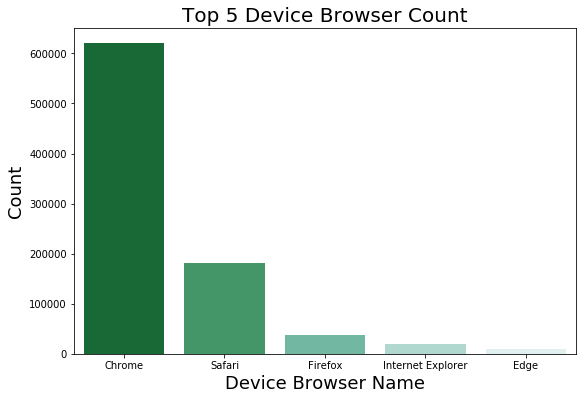

In [32]:
# seting the graph size
plt.figure(figsize=(9,6))
browser_order = dataNew2["device.browser"].value_counts()[:5].sort_values(ascending=False).index

# let explore the browser used by users
sns.countplot(dataNew2["device.browser"], order=browser_order, palette='BuGn_r')
plt.title("Top 5 Device Browser Count", fontsize=20) # seting the title size
plt.xlabel("Device Browser Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

The top 5 browsers are Chrome, Safari, Firefox, Internet Explorer, and Edge

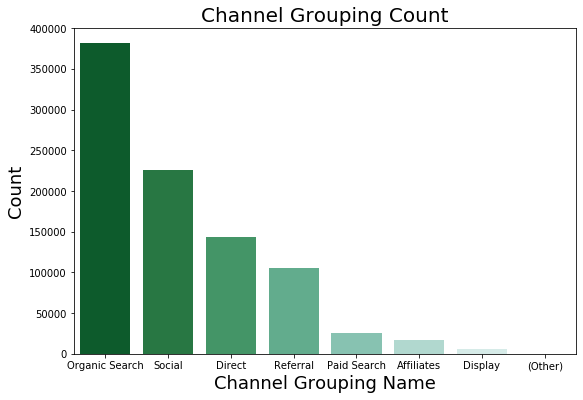

In [33]:
# seting the graph size
plt.figure(figsize=(9,6))
channel_order = dataNew2["channelGrouping"].value_counts().sort_values(ascending=False).index

sns.countplot(dataNew2["channelGrouping"], order=channel_order, palette='BuGn_r')
#Paired, Set2, hls
plt.title("Channel Grouping Count", fontsize=20) # seting the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

After counting the channel, we can see user used the Organic Search the most. Next are Social, Direct, and Referral.

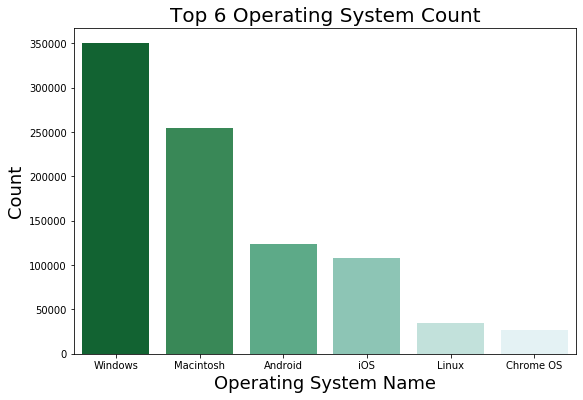

In [34]:
# seting the graph size
plt.figure(figsize=(9,6))
operatingSystem_order = dataNew2["device.operatingSystem"].value_counts()[:6].sort_values(ascending=False).index

sns.countplot(dataNew2["device.operatingSystem"], order=operatingSystem_order, palette='BuGn_r')
plt.title("Top 6 Operating System Count", fontsize=20) # seting the title size
plt.xlabel("Operating System Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

Top 6 operating systems are Windows, Macintosh, Android, iOS, Linux, Chrome OS

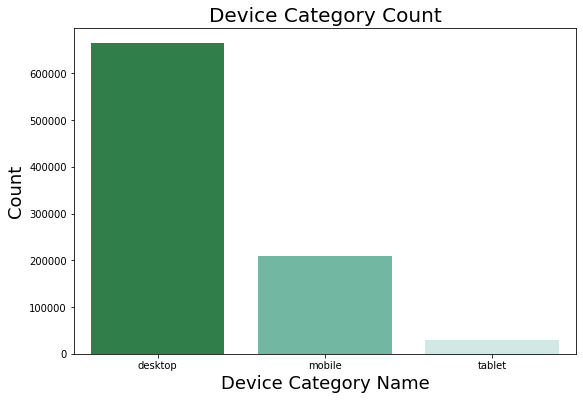

In [35]:
# seting the graph size
plt.figure(figsize=(9,6))
deviceCategory_order = dataNew2["device.deviceCategory"].value_counts().sort_values(ascending=False).index

sns.countplot(dataNew2["device.deviceCategory"], order=deviceCategory_order, palette='BuGn_r')
plt.title("Device Category Count", fontsize=20) # seting the title size
plt.xlabel("Device Category Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

From the above plot, we can see users tend to use desktop, then mobile, lastly, tablet.

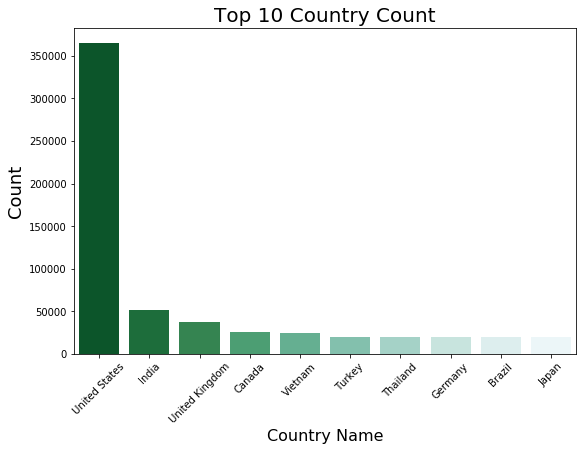

In [36]:
# seting the graph size
plt.figure(figsize=(9,6))
country_order = dataNew2["geoNetwork.country"].value_counts()[:10].sort_values(ascending=False).index

sns.countplot(dataNew2["geoNetwork.country"], order=country_order, palette='BuGn_r')
plt.title("Top 10 Country Count", fontsize=20) # seting the title size
plt.xlabel("Country Name", fontsize=16) # seting the x label size
plt.xticks(rotation=45)
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

Top 10 countries that users come from are United States, Undia, United Kingdom, Canada, Vietnam, Turkey, Thailand, Germany, Brazil, and Japan

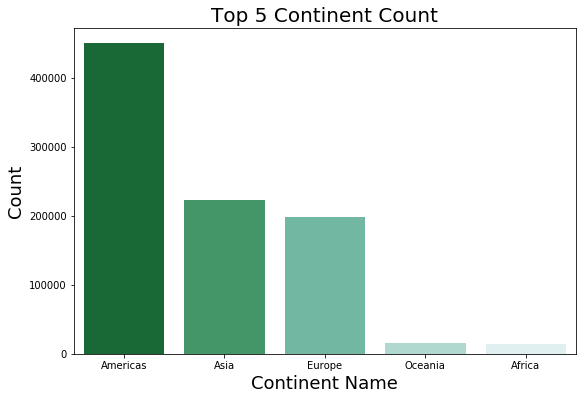

In [37]:
plt.figure(figsize=(9,6))
continent_order = dataNew2["geoNetwork.continent"].value_counts()[:5].sort_values(ascending=False).index

sns.countplot(dataNew2["geoNetwork.continent"], order=continent_order, palette='BuGn_r')
plt.title("Top 5 Continent Count", fontsize=20) # seting the title size
plt.xlabel("Continent Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

Americas is the first Continent that has the most traffic.

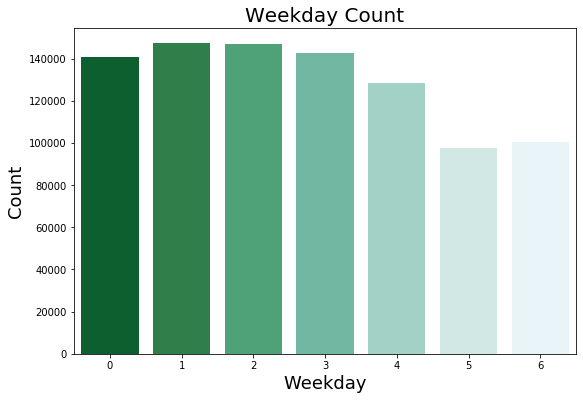

In [38]:
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["_weekday"], palette='BuGn_r')
plt.title("Weekday Count", fontsize=20) # seting the title size
plt.xlabel("Weekday", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

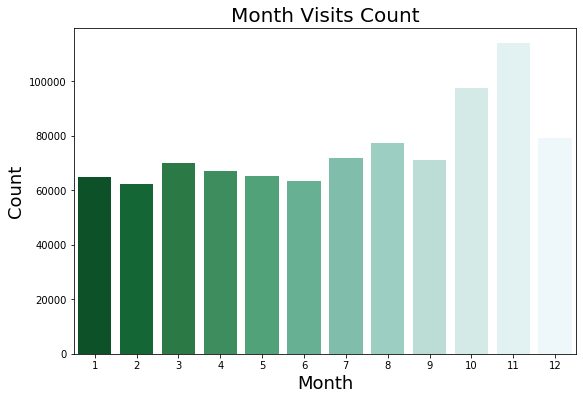

In [39]:
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["_month"], palette='BuGn_r')
plt.title("Month Visits Count", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

### Transactions

In [40]:
nz_revenue= pd.notnull(dataNew2["totals.transactionRevenue"]).sum()
print(f"The number of non-zero transaction is {nz_revenue} \nThe ratio is {nz_revenue/dataNew2.shape[0]}")

The number of non-zero transaction is 903653 
The ratio is 1.0


In [41]:
nz_revenue_df = dataNew2.loc[dataNew2["totals.transactionRevenue"]>0] #create a new df with only non-zero transactions
nz_revenue_df.head(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,_weekday,_day,_month,_year,_visitHour
752,Direct,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,1472843572,Chrome,Linux,False,...,Ann Arbor,(not set),11.0,11.0,37860000.0,4,2,9,2016,15
753,Organic Search,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,1472844906,Chrome,Macintosh,False,...,New York,(not set),11.0,10.0,306670000.0,4,2,9,2016,15
799,Referral,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,1472827393,Chrome,Linux,False,...,New York,(not set),13.0,11.0,68030000.0,4,2,9,2016,10
802,Referral,2016-09-02,0185467632009737931,0185467632009737931_1472846398,1472846398,6,1472846398,Chrome,Windows,False,...,Mountain View,(not set),13.0,12.0,26250000.0,4,2,9,2016,15
859,Referral,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,1472824817,Chrome,Macintosh,False,...,not available in demo dataset,(not set),17.0,14.0,574150000.0,4,2,9,2016,10


In [42]:
nz_revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 26 columns):
channelGrouping              11515 non-null object
date                         11515 non-null datetime64[ns]
fullVisitorId                11515 non-null object
sessionId                    11515 non-null object
visitId                      11515 non-null int64
visitNumber                  11515 non-null int64
visitStartTime               11515 non-null int64
device.browser               11515 non-null object
device.operatingSystem       11515 non-null object
device.isMobile              11515 non-null bool
device.deviceCategory        11515 non-null object
geoNetwork.continent         11515 non-null object
geoNetwork.subContinent      11515 non-null object
geoNetwork.country           11515 non-null object
geoNetwork.region            11515 non-null object
geoNetwork.metro             11515 non-null object
geoNetwork.city              11515 non-null object
geoNetwork.network

In [43]:
top5_broswer = ["Chrome", "Safari", "Firefox", "Internet Explorer", "Edge"]

Pageview - Date

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

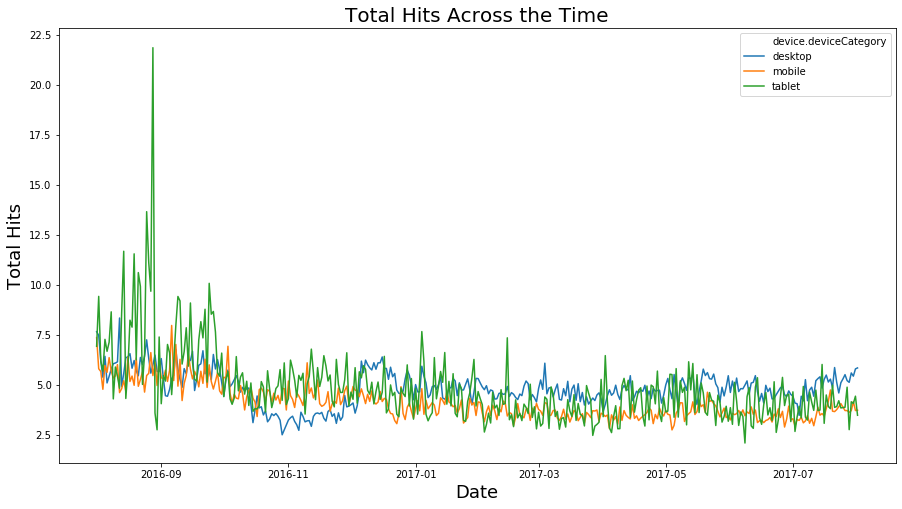

In [44]:
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=dataNew2, ci=None, hue="device.deviceCategory")
plt.title("Total Hits Across the Time", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

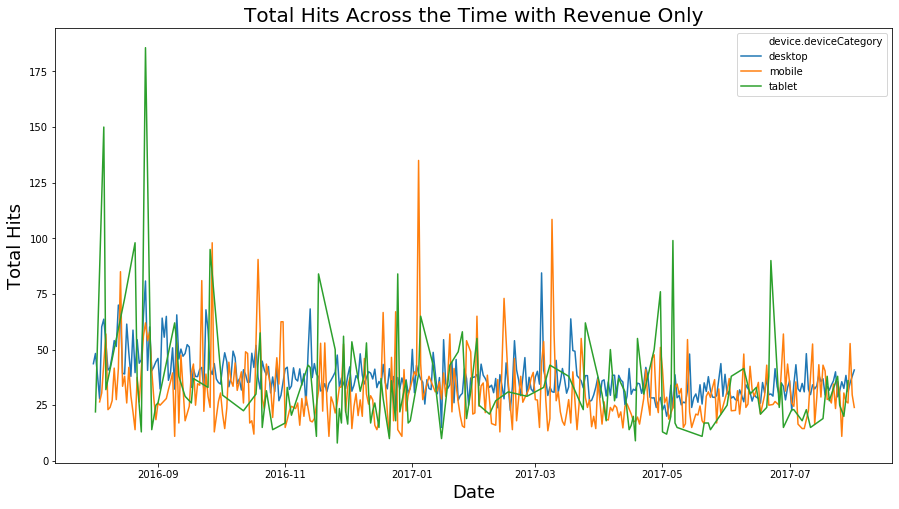

In [45]:
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=nz_revenue_df, ci=None, hue="device.deviceCategory")
plt.title("Total Hits Across the Time with Revenue Only", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

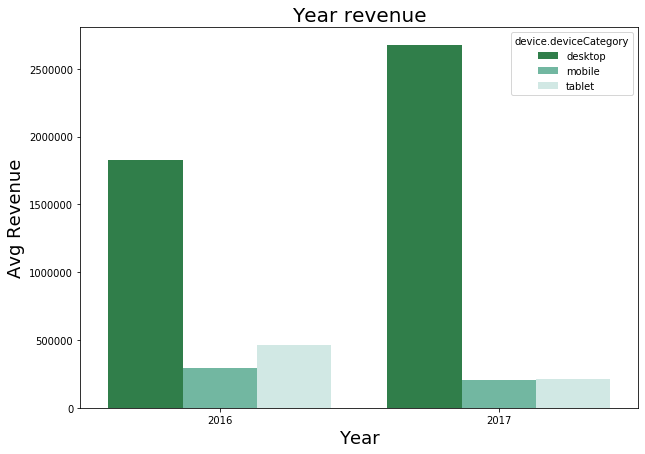

In [46]:
plt.figure(figsize=(10,7))

sns.barplot(x="_year", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='BuGn_r', ci=None)
plt.title("Year revenue", fontsize=20) # seting the title size
plt.xlabel("Year", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

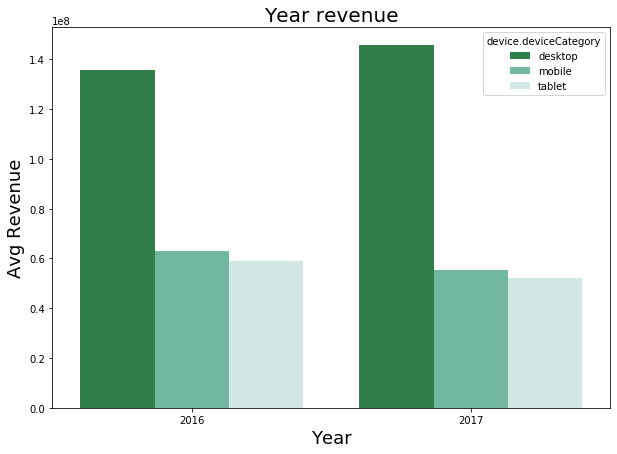

In [47]:
plt.figure(figsize=(10,7))

sns.barplot(x="_year", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='BuGn_r', ci=None)
plt.title("Year revenue", fontsize=20) # seting the title size
plt.xlabel("Year", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

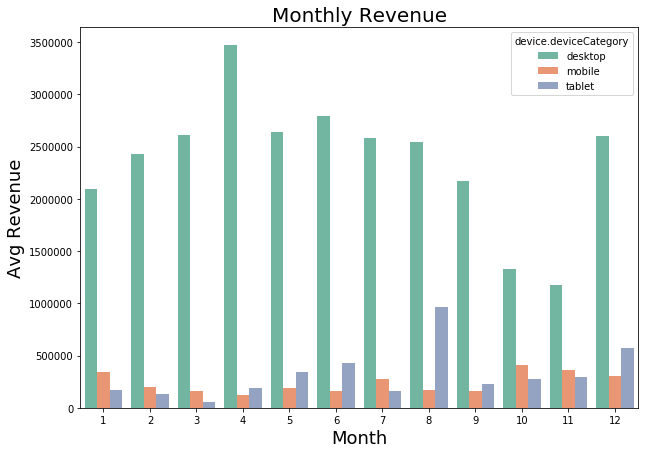

In [48]:
plt.figure(figsize=(10,7))

sns.barplot(x="_month", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='Set2', ci=None)
plt.title("Monthly Revenue", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

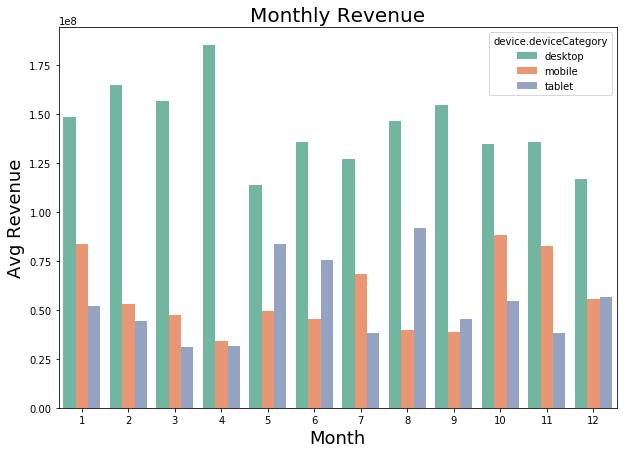

In [49]:
plt.figure(figsize=(10,7))

sns.barplot(x="_month", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='Set2', ci=None)
plt.title("Monthly Revenue", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

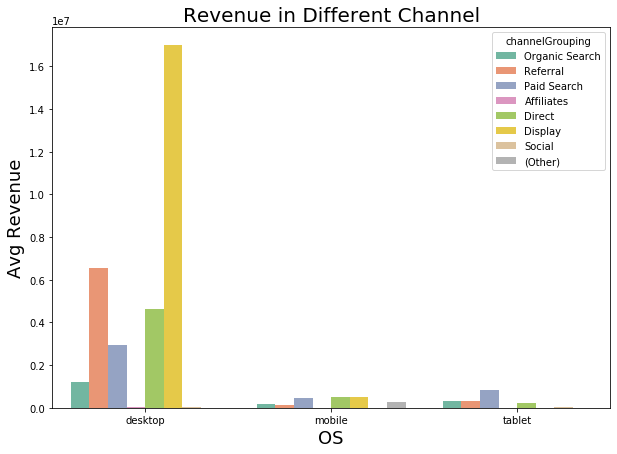

In [50]:
plt.figure(figsize=(10,7))

sns.barplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping", data=dataNew2, palette='Set2', ci=None)
plt.title("Revenue in Different Channel", fontsize=20) # seting the title size
plt.xlabel("OS", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

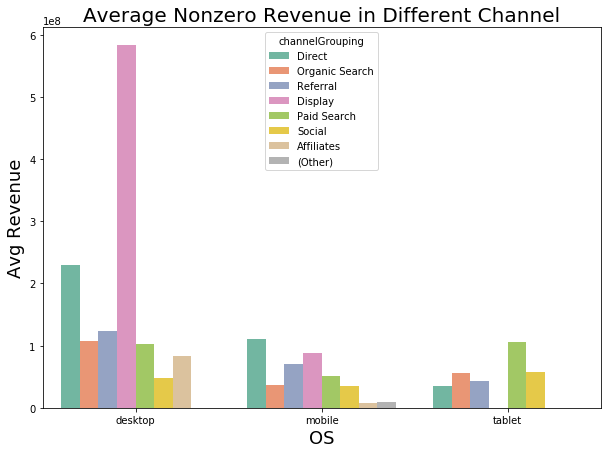

In [51]:
plt.figure(figsize=(10,7))

sns.barplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping", data=nz_revenue_df, palette='Set2', ci=None)
plt.title("Average Nonzero Revenue in Different Channel", fontsize=20) # seting the title size
plt.xlabel("OS", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

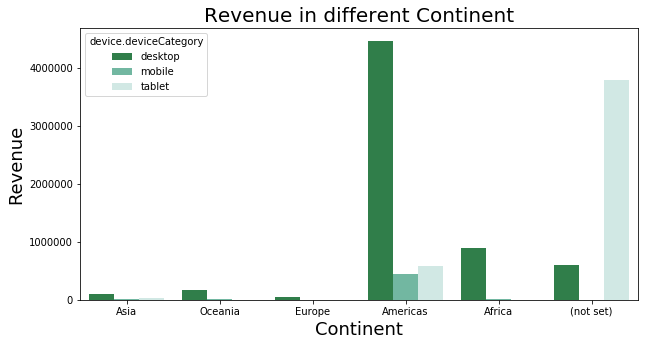

In [52]:
plt.figure(figsize=(10,5))

sns.barplot(x="geoNetwork.continent", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='BuGn_r', ci=None)
plt.title("Revenue in different Continent", fontsize=20) # seting the title size
plt.xlabel("Continent", fontsize=18) # seting the x label size
plt.ylabel("Revenue", fontsize=18) # seting the y label size

plt.show()

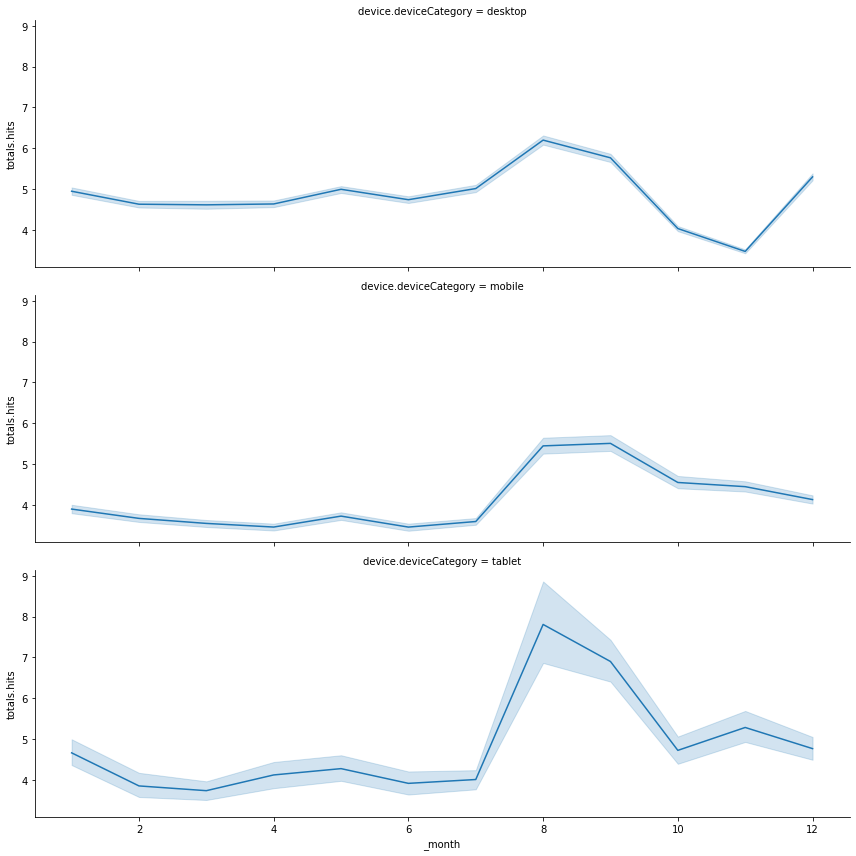

In [53]:
g = sns.FacetGrid(dataNew2, row="device.deviceCategory", height=4, aspect=3)
g = g.map(sns.lineplot, "_month", "totals.hits")

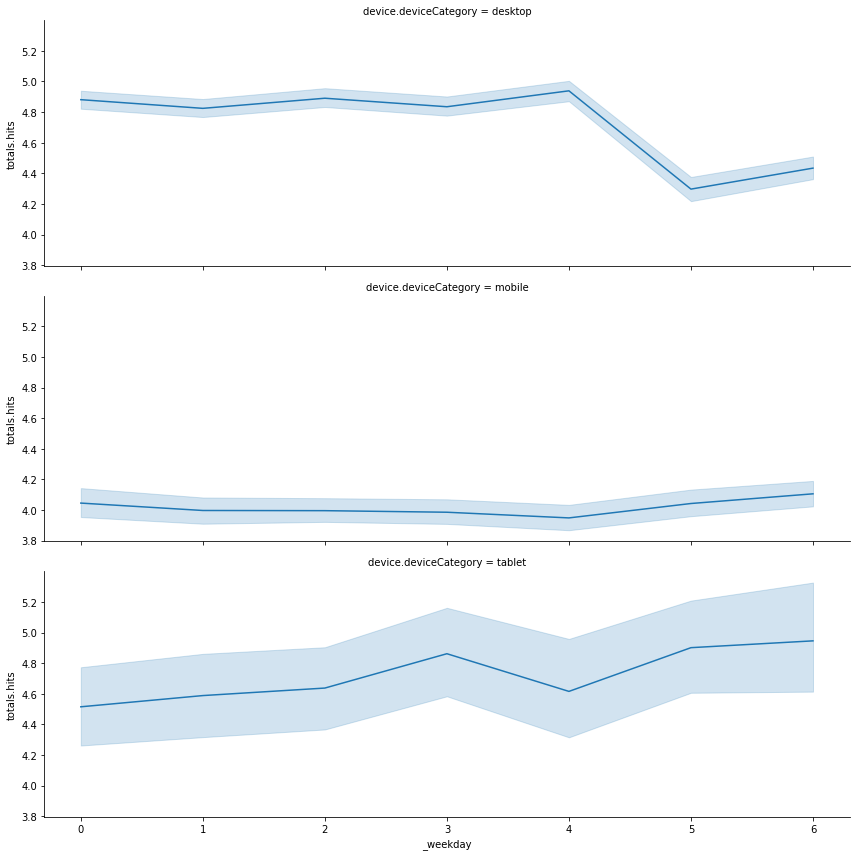

In [54]:
g = sns.FacetGrid(dataNew2, row="device.deviceCategory", height=4, aspect=3)
g = g.map(sns.lineplot, "_weekday", "totals.hits")

In [55]:
# Create Spark  Dataframe

In [56]:
sparkDF = spark.createDataFrame(dataNew2)

In [57]:
sparkDF.show(5)

+---------------+-------------------+-------------------+--------------------+----------+-----------+--------------+--------------+----------------------+---------------+---------------------+--------------------+-----------------------+------------------+--------------------+--------------------+--------------------+------------------------+-----------+----------------+-------------------------+--------+----+------+-----+----------+
|channelGrouping|               date|      fullVisitorId|           sessionId|   visitId|visitNumber|visitStartTime|device.browser|device.operatingSystem|device.isMobile|device.deviceCategory|geoNetwork.continent|geoNetwork.subContinent|geoNetwork.country|   geoNetwork.region|    geoNetwork.metro|     geoNetwork.city|geoNetwork.networkDomain|totals.hits|totals.pageviews|totals.transactionRevenue|_weekday|_day|_month|_year|_visitHour|
+---------------+-------------------+-------------------+--------------------+----------+-----------+--------------+--------

In [63]:
sparkDF.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- fullVisitorId: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- visitId: long (nullable = true)
 |-- visitNumber: long (nullable = true)
 |-- visitStartTime: long (nullable = true)
 |-- device.browser: string (nullable = true)
 |-- device.operatingSystem: string (nullable = true)
 |-- device.isMobile: boolean (nullable = true)
 |-- device.deviceCategory: string (nullable = true)
 |-- geoNetwork.continent: string (nullable = true)
 |-- geoNetwork.subContinent: string (nullable = true)
 |-- geoNetwork.country: string (nullable = true)
 |-- geoNetwork.region: string (nullable = true)
 |-- geoNetwork.metro: string (nullable = true)
 |-- geoNetwork.city: string (nullable = true)
 |-- geoNetwork.networkDomain: string (nullable = true)
 |-- totals.hits: double (nullable = true)
 |-- totals.pageviews: double (nullable = true)
 |-- totals.transactionRevenue: double (nullable = t

In [93]:
sparkDF.createOrReplaceTempView('viewDF')

In [94]:
start_time = time()
spark.sql("SELECT channelGrouping, COUNT(*) FROM viewDF GROUP BY channelGrouping ORDER BY COUNT(*) DESC LIMIT 7").show()
end_time = time()
time_taken = end_time - start_time
time_taken

KeyboardInterrupt: 

In [90]:
#Top 5 Device Browser Count
spark.sql("SELECT channelGrouping FROM viewDF LIMIT 5").show()

KeyboardInterrupt: 

In [ ]:
#Channel Grouping Count
spark.sql("""SELECT COUNT(*) \
            FROM sparkDF \
            GROUP BY channelGrouping \
            ORDER BY COUNT(*) \
            LIMIT 5""").show()

In [ ]:
#Top 6 Operating System Count
spark.sql("""SELECT COUNT(*) \
            FROM sparkDF \
            GROUP BY device.operatingSystem \
            ORDER BY COUNT(*) \
            LIMIT 6""").show()

In [ ]:
# Device Category Count
spark.sql("""SELECT COUNT(*) \
            FROM sparkDF \
            GROUP BY device.deviceCategory \
            ORDER BY COUNT(*) \
            LIMIT 6""").show()

In [ ]:
# Top 10 Country Count
spark.sql("""SELECT COUNT(*) \
            FROM sparkDF \
            GROUP BY geoNetwork.country \
            ORDER BY COUNT(*) \
            LIMIT 6""").show()

In [ ]:
spark.sql("""SELECT AVG(totals.transactionRevenue) as AvgRevenue \
             FROM sparkDF \
             GROUP BY device.deviceCategory, _year \
             ORDER BY AVG(totals.transactionRevenue) \
             LIMIT 10""").show()

In [ ]:
spark.sql("""SELECT device.deviceCategory, channelGrouping,  AVG(totals.transactionRevenue) as AvgRevenue
            FROM sparkDF
            GROUP BY device.deviceCategory, channelGrouping 
            ORDER BY COUNT(*), channelGrouping 
            """).show()

In [ ]:
spark.sql("""SELECT device.deviceCategory, _month,  AVG(totals.transactionRevenue) as AvgRevenue
            FROM sparkDF
            GROUP BY device.deviceCategory, _month 
            ORDER BY COUNT(*), _month 
            """).show()

In [ ]:
# transactionRevenue_mean = pd.DataFrame(dataNew2.groupby(['_year', 'device.deviceCategory']).mean()['totals.transactionRevenue'])
# print(transactionRevenue_mean)

In [ ]:
# with pd.option_context('display.float_format', '{:0.10f}'.format):
#     print(transactionRevenue_mean)

In [86]:
#Convert json to dataset
new_df = sqlContext.read.json(pure_json_df.rdd.map(lambda r: r.json))

In [87]:
new_df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)



In [88]:
new_df.show()

+--------------------+
|     _corrupt_record|
+--------------------+
|0         {"brows...|
|0         {"conti...|
|0         {"visit...|
|0         {"campa...|
+--------------------+



In [44]:
sqlContext.read.json(data.select("device").rdd.map(_.getAs[String](0)))

AttributeError: 'DataFrame' object has no attribute 'select'

In [10]:

# Columns that have json format
json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
nrows = None
#csv_path = dir_path + df
df = pd.read_csv("train.csv", 
                converters={column: json.loads for column in json_columns}, 
                dtype={'fullVisitorId': 'str'}, # Important!!
                nrows=nrows)

In [18]:
df_spark = sqlContext.createDataFrame(df)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.readRDDFromFile.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.api.java.JavaRDD$.readRDDFromInputStream(JavaRDD.scala:237)
	at org.apache.spark.api.java.JavaRDD$.readRDDFromFile(JavaRDD.scala:224)
	at org.apache.spark.api.python.PythonRDD$.readRDDFromFile(PythonRDD.scala:262)
	at org.apache.spark.api.python.PythonRDD.readRDDFromFile(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)


In [ ]:
df_to_rdd = df_spark.rdd.map(lambda x : load_df(x))

In [18]:
import multiprocessing as mp
pool = mp.Pool(3)
data_json = pool.apply(load_df(data))

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U30'), dtype('<U30')) -> dtype('<U30')

In [51]:
#DataFrame
df_data = spark.read.format('csv').option('header','true').option('inferSchema','true').load("train.csv")

In [6]:
df_data.head(10) #It's a DataFrame

[Row(channelGrouping='Organic Search', date=20160902, device='"{""browser"": ""Chrome""', fullVisitorId=' ""browserVersion"": ""not available in demo dataset""', geoNetwork=' ""browserSize"": ""not available in demo dataset""', sessionId=' ""operatingSystem"": ""Windows""', socialEngagementType=' ""operatingSystemVersion"": ""not available in demo dataset""', totals=' ""isMobile"": false', trafficSource=' ""mobileDeviceBranding"": ""not available in demo dataset""', visitId=' ""mobileDeviceModel"": ""not available in demo dataset""', visitNumber=' ""mobileInputSelector"": ""not available in demo dataset""', visitStartTime=' ""mobileDeviceInfo"": ""not available in demo dataset""'),
 Row(channelGrouping='Organic Search', date=20160902, device='"{""browser"": ""Firefox""', fullVisitorId=' ""browserVersion"": ""not available in demo dataset""', geoNetwork=' ""browserSize"": ""not available in demo dataset""', sessionId=' ""operatingSystem"": ""Macintosh""', socialEngagementType=' ""operat

In [42]:
df_data_jason = df_data.withColumn(lambda x: (load_df(x,nrows=None)))

TypeError: withColumn() missing 1 required positional argument: 'col'

In [52]:
df2 = df_data.rdd.flatMap(lambda x: (load_df(x,nrows=None))).toDF()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2.0 (TID 24, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-52-65893d31bb43>", line 1, in <lambda>
  File "<ipython-input-39-27881a8b0698>", line 5, in load_df
TypeError: can only concatenate str (not "Row") to str

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-52-65893d31bb43>", line 1, in <lambda>
  File "<ipython-input-39-27881a8b0698>", line 5, in load_df
TypeError: can only concatenate str (not "Row") to str

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	... 1 more


In [53]:
#RDD
df_data_RDD = sc.textFile("train.csv")

In [54]:
df_data_RDD

train.csv MapPartitionsRDD[4] at textFile at NativeMethodAccessorImpl.java:0

In [92]:
df_data_RDD_jason = df_data_RDD.map(lambda x: (load_df(x,nrows=None)))

In [93]:
df_data_RDD_jason.take(10)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 20.0 failed 1 times, most recent failure: Lost task 0.0 in stage 20.0 (TID 71, huang-chins-mbp.fios-router.home, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/rdd.py", line 1440, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-92-34ca181abdcc>", line 1, in <lambda>
  File "<ipython-input-91-a1b428b511b4>", line 10, in load_df
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1135, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1917, in __init__
    self._reader = parsers.TextReader(src, **kwds)
  File "pandas/_libs/parsers.pyx", line 382, in pandas._libs.parsers.TextReader.__cinit__
  File "pandas/_libs/parsers.pyx", line 689, in pandas._libs.parsers.TextReader._setup_parser_source
FileNotFoundError: [Errno 2] File b'channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime' does not exist: b'channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2133)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:154)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/rdd.py", line 1440, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-92-34ca181abdcc>", line 1, in <lambda>
  File "<ipython-input-91-a1b428b511b4>", line 10, in load_df
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1135, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1917, in __init__
    self._reader = parsers.TextReader(src, **kwds)
  File "pandas/_libs/parsers.pyx", line 382, in pandas._libs.parsers.TextReader.__cinit__
  File "pandas/_libs/parsers.pyx", line 689, in pandas._libs.parsers.TextReader._setup_parser_source
FileNotFoundError: [Errno 2] File b'channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime' does not exist: b'channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2133)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	... 1 more


In [97]:
sc.stop()

In [98]:
spark.stop()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51763)
Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:51763)